## CMPE547 Bayesian Statistics & Machine Learning by A. Taylan Cemgil
### Final Project: ITEM BASED COLLABORATIVE FILTERING RECOMMENDATION SYSTEM USING BAYESIAN NETWORKS 
##### Kaan Aytekin, Sena Sanioğlu, İlker Kurtuluş

In our project, we developed an item-based collaborative filtering model using Bayesian Networks. 
Collaborative filtering is one of the most successful and extensive technologies to date. For example, given a record of the target customer action, we can compare it with other customers’ history records by means of collaborative filtering.

#### Load Libraries. pgmpy is the core package for this work :https://github.com/pgmpy/pgmpy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
import warnings
from pgmpy.estimators import ConstraintBasedEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
from random import random,sample,seed
from sklearn import metrics
warnings.simplefilter("ignore")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from pgmpy.models import NaiveBayes

### Read Transaction Data

#### Dataset is publicly available at https://archive.ics.uci.edu/ml/datasets/online+retail 

##### We've transformed the data based invoices and encoded products. Preprocessing the data can be done quite easily thus we didnt share this basic step.

In [2]:
with open("data.pkl", "rb") as fp:
    data=pickle.load(fp)

In [3]:
data.iloc[:5,:8]

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE
536365.0,0,0,0,0,0,0,0,0
536366.0,0,0,0,0,0,0,0,0
536367.0,0,0,0,0,0,0,0,0
536368.0,0,0,0,0,0,0,0,0
536369.0,0,0,0,0,0,0,0,0


##### Delete products with sale volume less than 150: We had to this due to scalibility. In a cluster this work can be done easily for the whole transaction data.

In [4]:
data=data.loc[:,data.sum()>150]

##### Delete products that are not actually products (check,nan)

In [5]:
data=data.loc[:, data.columns.difference(["check","nan"])]

In [6]:
data.head()

,DOLLY GIRL BEAKER,OVAL WALL MIRROR DIAMANTE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,YOU'RE CONFUSING ME METAL SIGN,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
536365.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train the data to obtain the most optimal Network or Load the already trained model

In [7]:
try:
    with open("Edges.txt", "rb") as fp:
        Edges=pickle.load(fp)
    with open("Nodes.txt", "rb") as fp:
        Nodes=pickle.load(fp)
    with open("CPD.txt", "rb") as fp:
        CPD=pickle.load(fp)
    with open("RandomColumns.txt", "rb") as fp:
        random_columns=pickle.load(fp)
    with open("RandomIndices.txt", "rb") as fp:
        random_indices=pickle.load(fp)
    model=BayesianModel()
    model.add_nodes_from(Nodes)
    model.add_edges_from(Edges)
    model.add_cpds(*CPD)
    data=data.iloc[:,random_columns]
    column_size=data.shape[1]
    #Delete invoices with all zeros from the data
    data=data[(data.T != 0).any()]
    row_size=data.shape[0]
    smallDF=data.iloc[random_indices,:]
    smallDF.shape
    PseudoCounts={}
    #Pseudocounts are given (1,1) for uniform
    for productName in smallDF.columns:
        PseudoCounts[productName]=[1,1]
except:
    #Select random invoice (2000) and products (50)
    seed(0)
    column_size=data.shape[1]
    random_columns=sample(range(column_size),100)
    data=data.iloc[:,random_columns]
    #Delete invoices with all zeros from the data
    data=data[(data.T != 0).any()]
    row_size=data.shape[0]
    random_indices=sample(range(row_size),2000)
    smallDF=data.iloc[random_indices,:]
    smallDF.shape
    PseudoCounts={}
    #Pseudocounts are given (1,1) for uniform
    for productName in smallDF.columns:
        PseudoCounts[productName]=[1,1]
    print('Existing network not found')
    est = ConstraintBasedEstimator(smallDF)
    print('Starting to estimate the model structure, might take a while...')
    start=time.time()
    model = est.estimate(significance_level=0.05)
    end=time.time()
    print('Time spent to estimate model structure {0}'.format(end-start))
    print('Edges of the model:')
    print(model.edges())
    print('Starting to estimate model parameters..')
    start=time.time()
    model.fit(smallDF,estimator=BayesianEstimator,prior_type='dirichlet', pseudo_counts=PseudoCounts)
    end=time.time()
    print('Time spent to estimete the model parameters {0}'.format(end-start))
    #Save edge ,node, CPD information
    Edges=model.edges()
    Nodes=model.nodes()
    CPD=model.get_cpds()
    with open("Edges.txt", "wb") as fp:
        pickle.dump(Edges, fp)

    with open("Nodes.txt", "wb") as fp:
        pickle.dump(Nodes, fp)

    with open("CPD.txt", "wb") as fp:
        pickle.dump(CPD, fp)

    with open("RandomColumns.txt", "wb") as fp:
        pickle.dump(random_columns, fp)

    with open("RandomIndices.txt", "wb") as fp:
        pickle.dump(random_indices, fp)
    ProductNames=smallDF.columns
    with open("ProductNames.txt", "wb") as fp:
        pickle.dump(ProductNames, fp)

try:
    with open("testSetIndicies.txt", "rb") as fp:
        testSetIndicies=pickle.load(fp)
except:
    testSetIndicies=sample(set(range(row_size))-set(random_indices),500)
    with open("testSetIndicies.txt", "wb") as fp:
        pickle.dump(testSetIndicies, fp)

### Test The Model 

In [8]:
testDF=data.iloc[testSetIndicies,:]
TrueValuesAndPredictions=[]
for index in range(testDF.shape[0]):
    if(index%50 == 0):
        print('Making prediction for invoice {0}/{1}'.format(index,testDF.shape[0]))
    testInstance=testDF.copy()
    testInstanceRow=testInstance.iloc[index,:]
    boughtItemsIndex=[i for i,x in enumerate(testInstanceRow==1) if x==True]
    unboughtItemsIndex=[i for i,x in enumerate(testInstanceRow==1) if x==False]
    #50% of the time predict for bought items 50% of the time predict for the unbought items
    if random()<0.5:
        itemToPredict=sample(boughtItemsIndex,1)
        DroppedColumnName=testInstanceRow.index[itemToPredict]
        testingInstanceDropped=testInstance.drop(DroppedColumnName,axis=1, inplace=False)
        predictedProbability=model.predict_probability(testingInstanceDropped.iloc[index].to_frame().transpose()).iloc[0,1]
        TrueValue=testInstance.iloc[index,itemToPredict].iloc[0]
        TrueValuesAndPredictions.append((TrueValue,predictedProbability))
    else:
        itemToPredict=sample(unboughtItemsIndex,1)
        DroppedColumnName=testInstanceRow.index[itemToPredict]
        testingInstanceDropped=testInstance.drop(DroppedColumnName,axis=1, inplace=False)
        predictedProbability=model.predict_probability(testingInstanceDropped.iloc[index].to_frame().transpose()).iloc[0,1]
        TrueValue=testInstance.iloc[index,itemToPredict].iloc[0]
        TrueValuesAndPredictions.append((TrueValue,predictedProbability))

Making prediction for invoice 0/500
Making prediction for invoice 50/500
Making prediction for invoice 100/500
Making prediction for invoice 150/500
Making prediction for invoice 200/500
Making prediction for invoice 250/500
Making prediction for invoice 300/500
Making prediction for invoice 350/500
Making prediction for invoice 400/500
Making prediction for invoice 450/500


### Evaluate the Model by Area Under ROC Curve

<Figure size 432x288 with 0 Axes>

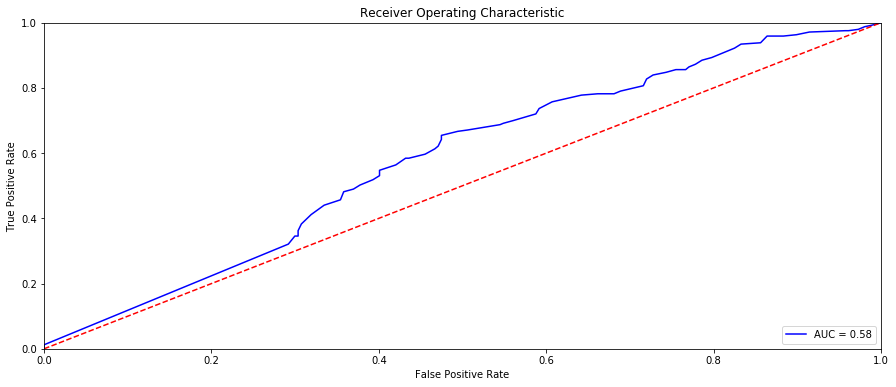

In [9]:
TrueValuesAndPredictionsSeparated=list(zip(*TrueValuesAndPredictions))
trueVals=TrueValuesAndPredictionsSeparated[0]
preds=TrueValuesAndPredictionsSeparated[1]
fpr, tpr, threshold = metrics.roc_curve(trueVals, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(num='ROC CURVE')
plt.figure(figsize = (15,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### In order to compare our work, we also trained a Naive Bayes Classifier

In [10]:
os.chdir(r"/".join(os.getcwd().split("/")[:-1]) + "/NaiveBayes")

In [11]:
with open("data.pkl", "rb") as fp:
    data=pickle.load(fp)

##### Delete products with sale volume less than 150

In [12]:
data=data.loc[:,data.sum()>150]

##### Delete products that are not actually products (check,nan)

In [13]:
data=data.loc[:, data.columns.difference(["check","nan"])]

In [14]:
data.head()

,DOLLY GIRL BEAKER,OVAL WALL MIRROR DIAMANTE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,YOU'RE CONFUSING ME METAL SIGN,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
536365.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train the data to obtain already trained model by NaiveBayes

In [15]:
try:
    with open("Edges.txt", "rb") as fp:
        Edges=pickle.load(fp)
    with open("Nodes.txt", "rb") as fp:
        Nodes=pickle.load(fp)
    with open("CPD.txt", "rb") as fp:
        CPD=pickle.load(fp)
    with open("RandomColumns.txt", "rb") as fp:
        random_columns=pickle.load(fp)
    with open("RandomIndices.txt", "rb") as fp:
        random_indices=pickle.load(fp)
    data=data.iloc[:,random_columns]
    column_size=data.shape[1]
    #Delete invoices with all zeros from the data
    data=data[(data.T != 0).any()]
    row_size=data.shape[0]
    smallDF=data.iloc[random_indices,:]
    smallDF.shape
    DictOfModels={}
    for productName in smallDF.columns:
        model = NaiveBayes()
        model.add_nodes_from(Nodes[productName])
        model.add_edges_from(Edges[productName])
        model.add_cpds(*CPD[productName])
        DictOfModels[productName]=model
        #Save edge ,node, CPD information
    PseudoCounts={}
    #Pseudocounts are given (1,1) for uniform
    print("Models were collected for all products")
    for productName in smallDF.columns:
        PseudoCounts[productName]=[1,1]
except:
    print('Existing model not found')
    #Select random invoice (2000) and products (50)
    seed(0)
    column_size=data.shape[1]
    random_columns=sample(range(column_size),100)
    data=data.iloc[:,random_columns]
    #Delete invoices with all zeros from the data
    data=data[(data.T != 0).any()]
    row_size=data.shape[0]
    random_indices=sample(range(row_size),2000)
    smallDF=data.iloc[random_indices,:]
    smallDF.shape
    PseudoCounts={}
    #Pseudocounts are given (1,1) for uniform
    for productName in smallDF.columns:
        PseudoCounts[productName]=[1,1]
    DictOfModels={}
    Edges={}
    Nodes={}
    CPD={}
    for productName in smallDF.columns:
        print('Building model for {0}'.format(productName))
        model = NaiveBayes()
        model.fit(smallDF,productName)
        DictOfModels[productName]=model
        #Save edge ,node, CPD information
        Edges[productName]=model.edges()
        Nodes[productName]=model.nodes()
        CPD[productName]=model.get_cpds()
    with open("Edges.txt", "wb") as fp:
        pickle.dump(Edges, fp)

    with open("Nodes.txt", "wb") as fp:
        pickle.dump(Nodes, fp)

    with open("CPD.txt", "wb") as fp:
        pickle.dump(CPD, fp)

    with open("RandomColumns.txt", "wb") as fp:
        pickle.dump(random_columns, fp)

    with open("RandomIndices.txt", "wb") as fp:
        pickle.dump(random_indices, fp)
    ProductNames=smallDF.columns
    with open("ProductNames.txt", "wb") as fp:
        pickle.dump(ProductNames, fp)

try:
    with open("testSetIndicies.txt", "rb") as fp:
        testSetIndicies=pickle.load(fp)
except:
    testSetIndicies=sample(set(range(row_size))-set(random_indices),500)
    with open("testSetIndicies.txt", "wb") as fp:
        pickle.dump(testSetIndicies, fp)	


Models were collected for all products


### Test The Model

In [16]:
testDF=data.iloc[testSetIndicies,:]
TrueValuesAndPredictions=[]
for index in range(testDF.shape[0]):
    if(index%50 == 0):
        print('Making prediction for invoice {0}/{1}'.format(index,testDF.shape[0]))
    testInstance=testDF.copy()
    testInstanceRow=testInstance.iloc[index,:]
    boughtItemsIndex=[i for i,x in enumerate(testInstanceRow==1) if x==True]
    unboughtItemsIndex=[i for i,x in enumerate(testInstanceRow==1) if x==False]
    #50% of the time predict for bought items 50% of the time predict for the unbought items
    if random()<0.5:
        itemToPredict=sample(boughtItemsIndex,1)
        DroppedColumnName=testInstanceRow.index[itemToPredict]
        testingInstanceDropped=testInstance.drop(DroppedColumnName,axis=1, inplace=False)
        predictedProbability=DictOfModels[DroppedColumnName[0]].predict_probability(testingInstanceDropped.iloc[index].to_frame().transpose()).iloc[0,1]
        #predictedProbability=model.predict_probability(testingInstanceDropped.iloc[index].to_frame().transpose()).iloc[0,1]
        TrueValue=testInstance.iloc[index,itemToPredict].iloc[0]
        TrueValuesAndPredictions.append((TrueValue,predictedProbability))
    else:
        itemToPredict=sample(unboughtItemsIndex,1)
        DroppedColumnName=testInstanceRow.index[itemToPredict]
        testingInstanceDropped=testInstance.drop(DroppedColumnName,axis=1, inplace=False)
        predictedProbability=DictOfModels[DroppedColumnName[0]].predict_probability(testingInstanceDropped.iloc[index].to_frame().transpose()).iloc[0,1]
        #predictedProbability=model.predict_probability(testingInstanceDropped.iloc[index].to_frame().transpose()).iloc[0,1]
        TrueValue=testInstance.iloc[index,itemToPredict].iloc[0]
        TrueValuesAndPredictions.append((TrueValue,predictedProbability))


Making prediction for invoice 0/500
Making prediction for invoice 50/500
Making prediction for invoice 100/500
Making prediction for invoice 150/500
Making prediction for invoice 200/500
Making prediction for invoice 250/500
Making prediction for invoice 300/500
Making prediction for invoice 350/500
Making prediction for invoice 400/500
Making prediction for invoice 450/500


### Evaluate the Model by Area Under ROC Curve

<Figure size 432x288 with 0 Axes>

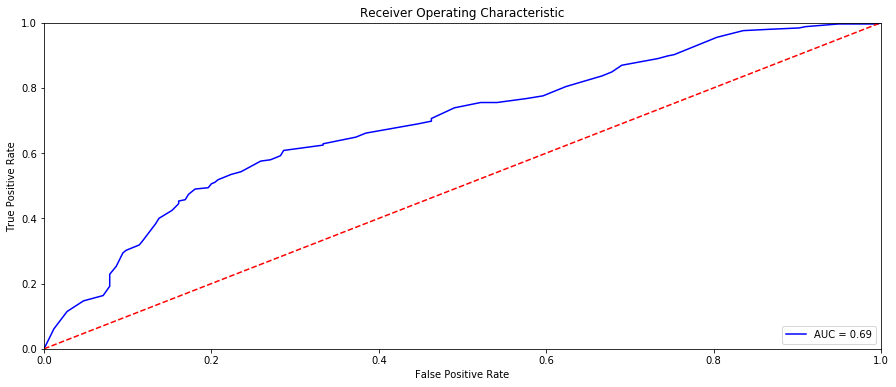

In [17]:
TrueValuesAndPredictionsSeparated=list(zip(*TrueValuesAndPredictions))
trueVals=TrueValuesAndPredictionsSeparated[0]
preds=TrueValuesAndPredictionsSeparated[1]
fpr, tpr, threshold = metrics.roc_curve(trueVals, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(num='ROC CURVE')
plt.figure(figsize = (15,6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Results show that naive bayes out performs the more sophisticated model, which shows that structure learning could not learn the actual model.
Both of the models performed poorly compared to the state-of-art recommendation engines, this is probably due to the sparsity of the purchase data, which results in a sparse network. Dimensionality reduction techniques outperform the Bayesian Networks due to this property and they are faster and more scalable. We do not recommend using Bayesian Networks as recommendation engines.

The reader also should note that due to lack of computational resources we had to limit some transactions which may cause difficulties at understanding customer behaviour and decrease in learning performance.